<h1> Lecture 21

Data Science 8, Summer 2021 </h1>

<h3>
<b>
<ul>
<li>Bootstrap</li><br>
    
<li>Confidence Intervals  </li><br>

<li>Interpretation of Confidence Intervals  </li>
</ul>
</b>
</h3>

In [1]:
from datascience import *
import numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
plots.rcParams["patch.force_edgecolor"] = True

#The following allows porting images into a Markdown window
#Syntax: ![title](image_name.png)
from IPython.display import Image

## Bootstrap: San Francisco City Salaries

The bootstrap lets us estimate the variability in an estimate.  In this case, we are estimating the median salary of all San Francisco employees, based on a sample of 300 employees (namely, the median salary of those 300 is our estimate for the population median); and we want to know about how much error this estimate will typically have.

<h2>City of San Francisco Employees: Sample Median</h2>

In [2]:
sf = Table.read_table('san_francisco_2015.csv')
sf

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",2481,Water Qualitytech I/II,21538,82146,0,0,82146,16942.2,12340.9,6337.73,35620.8,117767
Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,7393,Soft Floor Coverer,5459,32165.8,973.19,848.96,33987.9,0,4587.51,2634.42,7221.93,41209.8
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",1636,Health Care Billing Clerk 2,41541,71311,5757.98,0,77069,14697.6,12424.5,6370.06,33492.2,110561
Calendar,2015,4,Community Health,DPH,Public Health,351,Municipal Executive Association - Miscellaneous,0900,Management,2620,Food Service Mgr Administrator,26718,28430.2,0,763.07,29193.3,0,4223.14,5208.51,9431.65,38625
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,790,"SEIU - Miscellaneous, Local 1021",8200,Protection & Apprehension,8201,School Crossing Guard,45810,7948.75,0,0,7948.75,0,2873.17,616.24,3489.41,11438.2
Calendar,2015,1,Public Protection,POL,Police,911,Police Officers' Association,Q000,Police Services,Q002,Police Officer,32906,2235,0,0,2235,490.36,286.72,176.57,953.65,3188.65
Calendar,2015,4,Community Health,DPH,Public Health,791,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,7506,187247,0,11704.1,198951,37683.7,12424.5,11221.7,61329.9,260281
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,253,"Transport Workers - Transit Operators, Local 250-A",9100,Street Transit,9163,Transit Operator,36773,66988.5,3512.88,2770.39,73271.8,19127.2,13203,5455.1,37785.3,111057
Calendar,2015,6,General Administration & Finance,CAT,City Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),12963,135190,0,1562.5,136752,27501.8,12424.5,10103,50029.3,186781
Calendar,2015,3,Human Welfare & Neighborhood Development,DSS,Human Services,535,"SEIU - Human Services, Local 1021",9700,Community Development,9703,Emp & Training Spec 2,35179,70474.8,147.28,1647.24,72269.3,14650.3,10696.9,5993.11,31340.3,103610


<h3>Declutter: Remove extraneous columns</h3>

In [3]:
sf=sf.select('Job','Total Compensation')
sf

Job,Total Compensation
Water Qualitytech I/II,117767
Soft Floor Coverer,41209.8
Health Care Billing Clerk 2,110561
Food Service Mgr Administrator,38625
School Crossing Guard,11438.2
Police Officer,3188.65
Nurse Practitioner,260281
Transit Operator,111057
Attorney (Civil/Criminal),186781
Emp & Training Spec 2,103610


<h4>Assume 
    <ul>
        <li> a minimum hourly wage of $10/hour in 2015.</li><br>
        <li> at least half-time employee (i.e., works at least 20 hours/week)</li>
    </ul>
</h4>

In [4]:
min_wage_per_hour = 10  #minimum hourly wage
hours_per_week    = 20  #half-time employee
weeks_per_year    = 52

min_salary=min_wage_per_hour * hours_per_week * weeks_per_year
min_salary

10400

<h4>Keep only the rows where 'Total Compensation' is at least <tt>min_salary</tt>:</h4>

In [5]:
sf = sf.where('Total Compensation', are.above(min_salary)).sort('Total Compensation', descending=True)
sf

Job,Total Compensation
Chief Investment Officer,648875
Asst Med Examiner,480509
Asst Med Examiner,427219
Dept Head V,426686
"Adm, SFGH Medical Center",422800
"Chief, Fire Department",418844
Executive Contract Employee,417848
Senior Physician Specialist,415457
Chief Of Police,414791
"Gen Mgr, Public Trnsp Dept",405050


<h4>Population Size:</h4>

In [6]:
sf.num_rows

38090

<h4>Median 'Total Compensation' of the entire data set:</h4>

In [7]:
pop_median = percentile(50, sf.column('Total Compensation'))
pop_median 

107516.69

<h4>Minimum 'Total Compensation' of the entire data set:</h4>

In [8]:
pop_min = sf.column('Total Compensation').min()
pop_min

10403.15

<h4>Maximum 'Total Compensation' of the entire data set:</h4>

In [9]:
pop_max = max(sf.column('Total Compensation'))
pop_max

648875.24

<h4>Set the histogram bins.</h4>

In [10]:
sf_bins = np.arange(0, 700000, 25000)
sf_bins

array([     0,  25000,  50000,  75000, 100000, 125000, 150000, 175000,
       200000, 225000, 250000, 275000, 300000, 325000, 350000, 375000,
       400000, 425000, 450000, 475000, 500000, 525000, 550000, 575000,
       600000, 625000, 650000, 675000])

<h4>Plot the Population Distribution</h4>

Popoulation Median = 107516.69


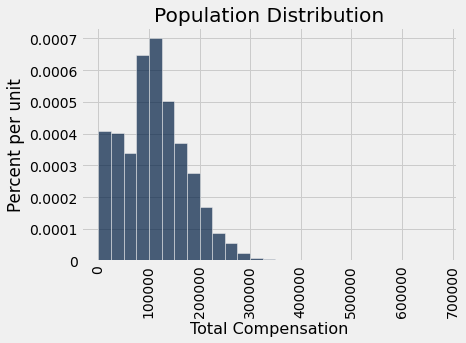

In [11]:
sf.hist('Total Compensation', bins=sf_bins)
plots.title('Population Distribution');
print("Popoulation Median =", pop_median)

<h4>Sample the population: use the sample median as an estimate of the population median.</h4> 

In [12]:
sample_size = 300
sample_size

300

In [13]:
our_sample = sf.sample(sample_size, with_replacement = False)
sample_median = percentile(50, our_sample.column('Total Compensation'))
print("Population median: $", pop_median)
print("Sample median: $", sample_median)

Population median: $ 107516.69
Sample median: $ 114390.42


In [14]:
def generate_sample_median(sample_size):
    our_sample = sf.sample(sample_size, with_replacement=False)
    return percentile(50, our_sample.column('Total Compensation'))

<h4>Now run a large number of trials.</h4> 

In [15]:
num_simulations = 1000
sample_size = 300

#Create a blank sample_medians array
sample_medians = make_array()

for i in np.arange(num_simulations):
    new_median = generate_sample_median(sample_size)
    sample_medians = np.append(sample_medians, new_median) #grow sample_medians array at each trial

<h4>Minimum and maximum sample medians:</h4>

In [16]:
print("Population median: $", pop_median)
print("Sample median: $", sample_median)

Population median: $ 107516.69
Sample median: $ 114390.42


<h4>Minimum Sample Median</h4>

In [17]:
min(sample_medians)

95228.87

<h4>Maximum Sample Median</h4>

In [18]:
max(sample_medians)

121701.44

<h4>Create the bins, informed by min and max median values</h4>

In [19]:
median_bins = np.arange(90000, 125001, 2500)

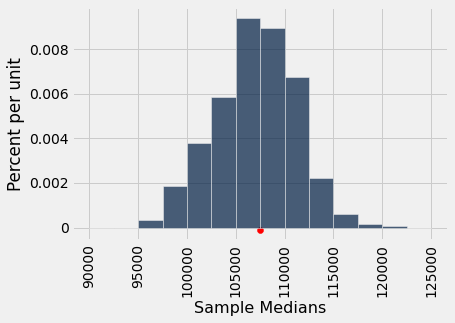

In [20]:
#Create the bins, informed by min and max median values
median_bins = np.arange(90000, 125001, 2500)
#Create the histogram
Table().with_column(
    'Sample Medians', sample_medians).hist(bins = median_bins)
#Superimpose the true population median
plots.scatter(pop_median, -1e-6, color="red");

# Bootstrap

<h4> Take One Bootstrap Resample from the Sample, and plot the histrogram.<br>
    
Run the following cell several times.</h4>

Population Median =        107516.69
Our Sample Median =        114390.42
Bootstrap Sample Median =  111071.33


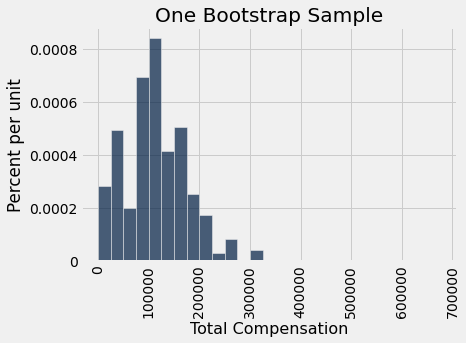

In [21]:
# Take a bootstrap (re)sample of size 300, WITH replacement
sample_size = 300

# We now sample, with replacement, from our_sample
boot_sample = our_sample.sample(sample_size, with_replacement=True)
boot_sample.hist('Total Compensation', bins=sf_bins)
plots.title('One Bootstrap Sample');

print("Population Median =       ", pop_median)
print("Our Sample Median =       ", sample_median)
print("Bootstrap Sample Median = ", 
      percentile(50,boot_sample.column('Total Compensation')))

<h4>Define function <tt>one_bootstrap_median</tt> that takes a resample from the sample.</h4>

In [22]:
def one_bootstrap_median(sample_size):
    boot_resample = our_sample.sample(sample_size,with_replacement=True)
    return percentile(50, boot_resample.column('Total Compensation'))

<h4>Run a large number of trials&mdash;take many resamples.</h4>

In [23]:
num_simulations = 1000

bootstrap_medians = make_array()
for i in np.arange(num_simulations):
    new_median = one_bootstrap_median(sample_size)
    bootstrap_medians = np.append(bootstrap_medians, new_median)

<h4>Median of the Bootstrap Medians</h4>

In [24]:
bootstrap_medians_table = Table().with_column(
    'Bootstrap Medians', bootstrap_medians
)
boot_median=percentile(50, bootstrap_medians_table.column('Bootstrap Medians'))

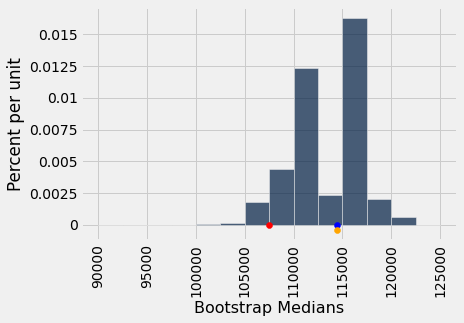

In [25]:
bootstrap_medians_table.hist('Bootstrap Medians', bins=median_bins)

plots.scatter(pop_median, 0, color="red", zorder=2);
plots.scatter(sample_median, 0, color="blue", zorder=2);
plots.scatter(boot_median, -4e-6, color="orange", zorder=3);

In [26]:
# Questions
# Slides

## Calculating Confidence Intervals with the Bootstrap

The confidence interval is an interval based on the middle 95% of bootstrap samples.  The interval will be shown in yellow, the sample median (our estimate) in blue, and the true population median (the parameter) in red.

Left End of CI: 106875.46
Right end of CI: 119322.78


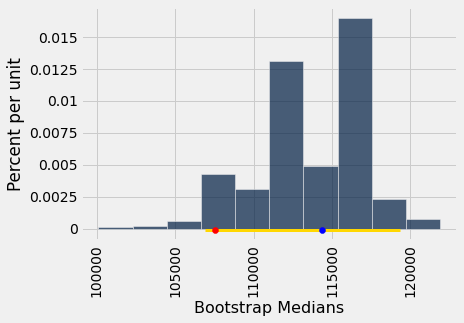

In [27]:
left = percentile(2.5, bootstrap_medians)
right = percentile(97.5, bootstrap_medians)

Table().with_column(
    'Bootstrap Medians', bootstrap_medians
).hist('Bootstrap Medians')

plots.plot([left, right], [-1e-6,-1e-6], color="gold", lw=3, zorder=1);
plots.scatter(pop_median, -1e-6, color="red", zorder=2);
plots.scatter(sample_median, -1e-6, color="blue", zorder=2);
print("Left End of CI:", left)
print("Right end of CI:", right)

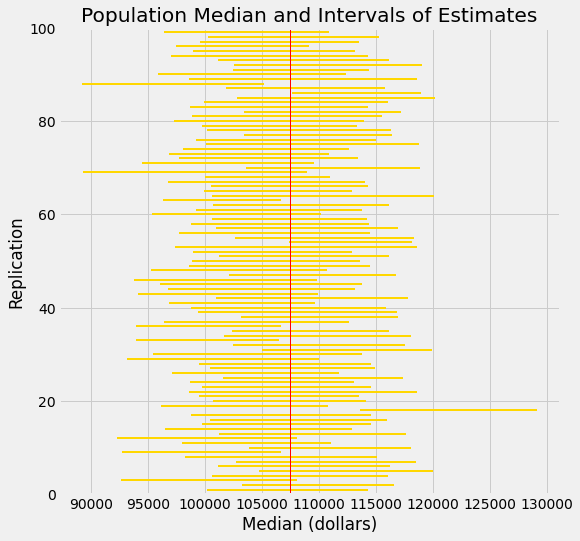

In [28]:
lowers = make_array()
uppers = make_array()

for i in np.arange(100):
    num_simulations = 1000
    bootstrap_medians = make_array()
    our_sample = sf.sample(sample_size, with_replacement = False)
    for i in np.arange(num_simulations):
        new_median = np.median(our_sample.sample().column("Total Compensation"))
        bootstrap_medians = np.append(bootstrap_medians, new_median)
    lower = percentile(2.5, bootstrap_medians)
    upper = percentile(97.5, bootstrap_medians)
    lowers = np.append(lowers, lower)
    uppers = np.append(uppers, upper)

plots.figure(figsize=(8,8));
for i in np.arange(100):
    plots.plot([lowers.item(i), uppers.item(i)], [i, i], color="gold", lw=2, zorder=1);
plots.plot([pop_median, pop_median], [-10, 100], color="red", zorder=2, lw=1);
plots.ylim(0, 100);
plots.title("Population Median and Intervals of Estimates");
plots.xlabel("Median (dollars)");
plots.ylabel("Replication");
